In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import numpy as np
import yfinance as yf

## Part 1: exploratory data analysis - The Forbes 2022 list of the top 100 employers
- Who are they?
- Where do they operate?
- How big are they by employee size?

In [5]:
# The original .csv of the 'Forbes Top 100 Employer Rankings'
# The list has been merged with each company's:
#     a) Overall Glassdoor Rating as at January 2023
#     b) Ticker symbol to enable financial analysis in section two
#     c) City of Headquarters  

filepath = "resources/employers_clean.csv"
employers_df = pd.read_csv(filepath)

In [6]:
#initial clean of data:
employers_df=employers_df.replace('South Kore','South Korea')
employers_df=employers_df.rename(columns={'RANK':'Forbes Ranking','NAME':'Employer','City':'HQ City','INDUSTRIES':'Sector','EMPLOYEES':'Number of employees'})
employers_df.set_index('Forbes Ranking')

employers_df.head()

,Forbes Ranking,Employer,TICKER,Sector,Country,Number of employees,Glassdoor Rating,HQ City
0,1,Samsung Electronics,005930.KS,"Semiconductors, Electronics, Electrical Engine...",South Korea,"266,673",3.8,Suwon
1,2,Microsoft,MSFT,"IT, Internet, Software & Services",United States,"221,000",4.4,Redmond
2,3,IBM,IBM,"Semiconductors, Electronics, Electrical Engine...",United States,"250,000",4.2,Armonk
3,4,Alphabet,GOOG,"IT, Internet, Software & Services",United States,"156,500",4.5,Mountain View
4,5,Apple,AAPL,"Semiconductors, Electronics, Electrical Engine...",United States,"154,000",4.1,Cupertino


In [8]:
#American and German companies account for more than half of the top 100
countrygroup=employers_df.groupby('Country')
countrygroup=countrygroup['Forbes Ranking'].count().sort_values(ascending=False)
countrygroup

Country
United States           40
Germany                 17
France                   8
Italy                    6
Japan                    5
South Korea              4
China                    4
Switzerland              3
Netherlands              3
Canada                   2
United Kingdom           2
Saudi Arabia             1
Singapore                1
Sweden                   1
India                    1
United Arab Emirates     1
Austria                  1
Name: Forbes Ranking, dtype: int64

In [9]:
sectorgroup=employers_df.groupby('Sector')
sectorgroup=sectorgroup['Sector'].count().sort_values(ascending=False)
sectorgroup

Sector
IT, Internet, Software & Services                                                       12
Aerospace & Defense                                                                     10
Automotive (Automotive and Suppliers)                                                   10
Banking and Financial Services                                                          10
Retail and Wholesale                                                                     8
Clothing, Shoes, Sports Equipment                                                        7
Engineering, Manufacturing                                                               7
Semiconductors, Electronics, Electrical Engineering, Technology Hardware & Equipment     6
Drugs & Biotechnology                                                                    6
Utilities                                                                                4
Conglomerate                                                                       

In [12]:
bins=[0, 100000, 250000, 500000, 2000000]
groups=["0 to \n99,999","100,000 to\n249,999", "250,000 to\n499,999","500,000+" ]

# employers_df['Number of employees']=employers_df['Number of employees'].str.replace(',','')
employers_df['Number of employees']=employers_df['Number of employees'].astype(int)
employers_df['company_size_bins'] = pd.cut(employers_df['Number of employees'],bins,labels=groups,include_lowest=True)

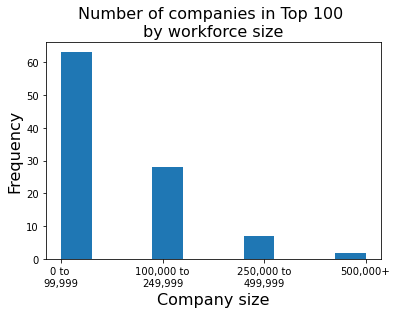

<Figure size 432x288 with 0 Axes>

In [15]:
companysize=employers_df['company_size_bins']
plt.hist(np.sort(companysize))
plt.xlabel("Company size", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Number of companies in Top 100 \nby workforce size",fontsize=16)
plt.show()
plt.savefig('images/countbysize.png')

## Part 2: Financial analysis of listed companies within Forbes list:
- Research question: do good employers make good investments?
- How do these companies stack up as investments on metrics such as: 12 month stock performance; return on equity, mean analysts recommendations.
- Yfinance wrapper library used to make call to the Yahoo Finance endpoint. Provides the abovementioned metrics within a dictionary through the method 'Ticker.info()'

In [ ]:
employers_financials=employers_df[['Forbes Ranking', 'Employer', 'TICKER','Sector','Country','Glassdoor Rating']]
employers_financials.set_index('Forbes Ranking')

In [ ]:
#This removes the companies without a ticker code
employers_reduced = employers_financials[employers_financials["TICKER"] != 'none'].reset_index(drop=True)


In [ ]:
#This adds new columns for the data that will be brought in using Yfinance
employers_reduced['1 year stock performance']=""
employers_reduced['return on equity']=""
employers_reduced['Analyst Recommendation Mean']=""
employers_reduced

In [ ]:
#This sets up a loop through the rows in the table and searchs each company on its ticker code
#The relevant information is added to the empty columns.
#It also prints the company information to the screen.
#If any of the data is missing, the loop returns "No data found"

print('Finding stock data..')
print("-"*20)
for index,row in employers_reduced.iterrows():
    company=employers_reduced.loc[index,'Employer']
    ticker=employers_reduced.loc[index,'TICKER']
    stock_data=yf.Ticker(ticker)
    try:
        employers_reduced.loc[index, "1 year stock performance"]=round(stock_data.info["52WeekChange"]*100,2)
        employers_reduced.loc[index, "return on equity"]=round(stock_data.info["returnOnEquity"]*100,2)
        employers_reduced.loc[index, "Analyst Recommendation Mean"]=stock_data.info['recommendationMean']
        
    except:
        employers_reduced.loc[index, "1 year stock performance"]="No data found"
        employers_reduced.loc[index, "return on equity"]="No data found"
        employers_reduced.loc[index, "Analyst Recommendation Mean"]="No data found"
        
        
    print(f"{company} ({ticker}): {employers_reduced.loc[index, '1 year stock performance']}% 1yr stock performance; {employers_reduced.loc[index, 'return on equity']}% RoE; Mean Analyst Rec: {employers_reduced.loc[index, 'Analyst Recommendation Mean']}")
    print("-"*20)

employers_reduced